# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=5,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-46-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5181 | MulticlassF1Score=0.0821
Batch-30 : CrossEntropyLoss=2.4784 | MulticlassF1Score=0.1732
Batch-45 : CrossEntropyLoss=2.4547 | MulticlassF1Score=0.2096
Batch-60 : CrossEntropyLoss=2.4686 | MulticlassF1Score=0.2318
Batch-75 : CrossEntropyLoss=2.4449 | MulticlassF1Score=0.2613
Batch-90 : CrossEntropyLoss=2.4253 | MulticlassF1Score=0.2952
Batch-105: CrossEntropyLoss=2.4174 | MulticlassF1Score=0.3182
Batch-120: CrossEntropyLoss=2.3825 | MulticlassF1Score=0.3469
Batch-135: CrossEntropyLoss=2.3807 | MulticlassF1Score=0.3806
Batch-150: CrossEntropyLoss=2.3528 | MulticlassF1Score=0.4095
Batch-165: CrossEntropyLoss=2.3654 | MulticlassF1Score=0.4326
Batch-180: CrossEntropyLoss=2.3569 | MulticlassF1Score=0.4527
Batch-195: CrossEntropyLoss=2.3478 | MulticlassF1Score=0.4693
Batch-210: CrossEntropyLoss=2.3414 | MulticlassF1Score=0.4843
Batch-225: CrossEntropyLoss=2.3438 | MulticlassF1Score=0.4970
Batch-226: CrossEntropyLoss=2.3279 | MulticlassF1Score=0.4978

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3483 | MulticlassF1Score=0.7100
Batch-30 : CrossEntropyLoss=2.3440 | MulticlassF1Score=0.7094
Batch-45 : CrossEntropyLoss=2.3487 | MulticlassF1Score=0.7099
Batch-60 : CrossEntropyLoss=2.3350 | MulticlassF1Score=0.7098
Batch-63 : CrossEntropyLoss=2.3330 | MulticlassF1Score=0.7096

Training   : Mean CrossEntropyLoss = 2.4136 | Mean MulticlassF1Score = 0.3229
Validation : Mean CrossEntropyLoss = 2.3411 | Mean MulticlassF1Score = 0.7106

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3397 | MulticlassF1Score=0.7155
Batch-30 : CrossEntropyLoss=2.3459 | MulticlassF1Score=0.7197
Batch-45 : CrossEntropyLoss=2.3229 | MulticlassF1Score=0.7157
Batch-60 : CrossEntropyLoss=2.3338 | MulticlassF1Score=0.7202
Batch-75 : CrossEntropyLoss=2.3233 | MulticlassF1Score=0.7299
Batch-90 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7373
Batch-105: CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7440
Batch-120: CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7494
Batch-135: CrossEntropyLoss=2.3119 | MulticlassF1Score=0.7535
Batch-150: CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7572
Batch-165: CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7604
Batch-180: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.7623
Batch-195: CrossEntropyLoss=2.3207 | MulticlassF1Score=0.7641
Batch-210: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7655
Batch-225: CrossEntropyLoss=2.3250 | MulticlassF1Score=0.7674
Batch-226: CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.7885
Batch-30 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7905
Batch-45 : CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7905
Batch-60 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7896
Batch-63 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7898

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3211 | Mean MulticlassF1Score = 0.7425
Validation : Mean CrossEntropyLoss = 2.3134 | Mean MulticlassF1Score = 0.7882

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7909
Batch-30 : CrossEntropyLoss=2.3226 | MulticlassF1Score=0.7911
Batch-45 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7928
Batch-60 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7948
Batch-75 : CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7936
Batch-90 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.7925
Batch-105: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7924
Batch-120: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7933
Batch-135: CrossEntropyLoss=2.3262 | MulticlassF1Score=0.7926
Batch-150: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7928
Batch-165: CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7927
Batch-180: CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7929
Batch-195: CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7936
Batch-210: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7935
Batch-225: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.7937
Batch-226: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7938

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.7981
Batch-30 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7943
Batch-45 : CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7955
Batch-60 : CrossEntropyLoss=2.3216 | MulticlassF1Score=0.7952
Batch-63 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.7951

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3119 | Mean MulticlassF1Score = 0.7922
Validation : Mean CrossEntropyLoss = 2.3113 | Mean MulticlassF1Score = 0.7953

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7982
Batch-30 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8002
Batch-45 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.7983
Batch-60 : CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7988
Batch-75 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7969
Batch-90 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7958
Batch-105: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7961
Batch-120: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7970
Batch-135: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7993
Batch-150: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8023
Batch-165: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8035
Batch-180: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8046
Batch-195: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8059
Batch-210: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8075
Batch-225: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8088
Batch-226: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8088

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8244
Batch-30 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8258
Batch-45 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8265
Batch-60 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8250
Batch-63 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8257

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3072 | Mean MulticlassF1Score = 0.8002
Validation : Mean CrossEntropyLoss = 2.3019 | Mean MulticlassF1Score = 0.8255

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8306
Batch-30 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.8334
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8323
Batch-60 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8312
Batch-75 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8300
Batch-90 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8299
Batch-105: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8304
Batch-120: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8303
Batch-135: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8302
Batch-150: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8304
Batch-165: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8309
Batch-180: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8309
Batch-195: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.8308
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8307
Batch-225: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8307
Batch-226: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8308

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8360
Batch-30 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8301
Batch-45 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8280
Batch-60 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8289
Batch-63 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8286

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8311
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8335

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8349
Batch-30 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8344
Batch-45 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8332
Batch-60 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8335
Batch-75 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8334
Batch-90 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8315
Batch-105: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8311
Batch-120: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8316
Batch-135: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8313
Batch-150: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8317
Batch-165: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8317
Batch-180: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8320
Batch-195: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8318
Batch-210: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8322
Batch-225: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8326
Batch-226: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8326

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8276
Batch-30 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8282
Batch-45 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8285
Batch-60 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8297
Batch-63 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8301

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8325
Validation : Mean CrossEntropyLoss = 2.3003 | Mean MulticlassF1Score = 0.8293

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.8327
Batch-30 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8354
Batch-45 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8357
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8373
Batch-75 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8374
Batch-90 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8366
Batch-105: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8355
Batch-120: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8354
Batch-135: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8351
Batch-150: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8347
Batch-165: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8350
Batch-180: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8352
Batch-195: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8349
Batch-210: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8346
Batch-225: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8342
Batch-226: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8343

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8274
Batch-30 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8311
Batch-45 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8302
Batch-60 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8299
Batch-63 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8300

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2989 | Mean MulticlassF1Score = 0.8352
Validation : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8292

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8358
Batch-30 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8376
Batch-45 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8350
Batch-60 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8362
Batch-75 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8365
Batch-90 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8360
Batch-105: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8372
Batch-120: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8381
Batch-135: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8382
Batch-150: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8392
Batch-165: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8398
Batch-180: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8398
Batch-195: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8408
Batch-210: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8417
Batch-225: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8424
Batch-226: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8548
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8526
Batch-45 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8518
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8506
Batch-63 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8515

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2965 | Mean MulticlassF1Score = 0.8384
Validation : Mean CrossEntropyLoss = 2.2939 | Mean MulticlassF1Score = 0.8520

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8674
Batch-30 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8643
Batch-45 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8629
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8635
Batch-75 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8628
Batch-90 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8615
Batch-105: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8611
Batch-120: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8602
Batch-135: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8606
Batch-150: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8610
Batch-165: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8610
Batch-180: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8612
Batch-195: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8610
Batch-210: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8604
Batch-225: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8599
Batch-226: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8599

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8551
Batch-30 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8538
Batch-45 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8550
Batch-60 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8549
Batch-63 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8545

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2912 | Mean MulticlassF1Score = 0.8623
Validation : Mean CrossEntropyLoss = 2.2926 | Mean MulticlassF1Score = 0.8542

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8627
Batch-30 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8596
Batch-45 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8591
Batch-60 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8595
Batch-75 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8606
Batch-90 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8616
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8621
Batch-120: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8623
Batch-135: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8626
Batch-150: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8623
Batch-165: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8618
Batch-180: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8615
Batch-195: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8616
Batch-210: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8617
Batch-225: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8616
Batch-226: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8617

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8526
Batch-30 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8539
Batch-45 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8549
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8560
Batch-63 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8553

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2905 | Mean MulticlassF1Score = 0.8613
Validation : Mean CrossEntropyLoss = 2.2924 | Mean MulticlassF1Score = 0.8538

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8640
Batch-30 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8665
Batch-45 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8657
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8664
Batch-75 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8644
Batch-90 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8644
Batch-105: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8638
Batch-120: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8644
Batch-135: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8641
Batch-150: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8639
Batch-165: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8638
Batch-180: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8633
Batch-195: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8631
Batch-210: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8633
Batch-225: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8632
Batch-226: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8553
Batch-30 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8573
Batch-45 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8589
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8570
Batch-63 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8570

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2900 | Mean MulticlassF1Score = 0.8646
Validation : Mean CrossEntropyLoss = 2.2919 | Mean MulticlassF1Score = 0.8562

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8648
Batch-30 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8619
Batch-45 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8624
Batch-60 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8630
Batch-75 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8638
Batch-90 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8645
Batch-105: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8645
Batch-120: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8651
Batch-135: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8653
Batch-150: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8658
Batch-165: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8660
Batch-180: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8658
Batch-195: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8657
Batch-210: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8661
Batch-225: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8662
Batch-226: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8663

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8563
Batch-30 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8582
Batch-45 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8587
Batch-60 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8585
Batch-63 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8584

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2891 | Mean MulticlassF1Score = 0.8647
Validation : Mean CrossEntropyLoss = 2.2914 | Mean MulticlassF1Score = 0.8573

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8694
Batch-30 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8682
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8674
Batch-60 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8676
Batch-75 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8672
Batch-90 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8679
Batch-105: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8684
Batch-120: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8684
Batch-135: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8683
Batch-150: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8680
Batch-165: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8676
Batch-180: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8676
Batch-195: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8678
Batch-210: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8673
Batch-225: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8673
Batch-226: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8628
Batch-30 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8599
Batch-45 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8591
Batch-60 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8588
Batch-63 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8585

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2887 | Mean MulticlassF1Score = 0.8678
Validation : Mean CrossEntropyLoss = 2.2913 | Mean MulticlassF1Score = 0.8610

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8720
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8769
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8805
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8843
Batch-75 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8861
Batch-90 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8880
Batch-105: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8885
Batch-120: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8901
Batch-135: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8915
Batch-150: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8922
Batch-165: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8926
Batch-180: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8928
Batch-195: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8932
Batch-210: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8938
Batch-225: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8942
Batch-226: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8942

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8943
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8913
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8919
Batch-60 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8899
Batch-63 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8901

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8874
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8924

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9060
Batch-30 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.9043
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9030
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9030
Batch-75 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9026
Batch-90 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9028
Batch-105: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9036
Batch-120: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9029
Batch-135: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9032
Batch-150: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9034
Batch-165: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9035
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9037
Batch-195: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9033
Batch-210: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9032
Batch-225: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9032
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9032

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8898
Batch-30 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8916
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.8908
Batch-60 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8914
Batch-63 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8916

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9033
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8900

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9075
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9060
Batch-45 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9069
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9080
Batch-75 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9075
Batch-90 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.9066
Batch-105: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.9061
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9066
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9064
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9062
Batch-165: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9059
Batch-180: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9061
Batch-195: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9060
Batch-210: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9063
Batch-225: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9059
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9059

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8896
Batch-30 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8920
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8927
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8914
Batch-63 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8917

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2768 | Mean MulticlassF1Score = 0.9064
Validation : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8911

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9044
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9088
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9106
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9104
Batch-75 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9100
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9099
Batch-105: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9096
Batch-120: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9094
Batch-135: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9088
Batch-150: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9095
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9110
Batch-180: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9126
Batch-195: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9138
Batch-210: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9151
Batch-225: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9162
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9162

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9174
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9166
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9188
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9191

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9105
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9174

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9382
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9361
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9369
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9369
Batch-105: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9364
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9364
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9365
Batch-165: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9363
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9360
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9359
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9358
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9362
Batch-226: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9362

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9211

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9364
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9238

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9378
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9370
Batch-75 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9373
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9376
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9378
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9376
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9381
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9377
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9379
Batch-195: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9380
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9378
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9377
Batch-226: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9377

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9376
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9235

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9381
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9383
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9383
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9381
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9386
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9386
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9386
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9386
Batch-180: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9387
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9389
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9390
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9390

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9193
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9220

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9384
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9197

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9406
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9408
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9408
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9404
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9404
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9406
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9405
Batch-180: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9405
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9405
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9404
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9404
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9404

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9405
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9220

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9393
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9409
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9400
Batch-75 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9400
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9400
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9399
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9403
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9404
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9409
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9410
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9412
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9413

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9218
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9209
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9405
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9212

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9421
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9428
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9422
Batch-135: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9417
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9419
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9419
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9417
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9416
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9417
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9418

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9220
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9419
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9220

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9418
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9416
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9416
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9416
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9423
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9272
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9428
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9271

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9446
Batch-75 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9450
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9450
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9457
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9453
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9452
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9455
Batch-226: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9455

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9260

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9460
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9457
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9454
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9455
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9454
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9253
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9260
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9256

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9460
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9265
Patience = 1/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9445
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9444
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9455
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9455
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9455
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9454
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9258

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9272
Patience = 2/50❗

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9520
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9513
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9501
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9496
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9489
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9484
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9468
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9467
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9460
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9272
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9484
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9257

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9472
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9469
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9465
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9463
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9460
Batch-225: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9461
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9461

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9256

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9475
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9479
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9476
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9470
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9469
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9470
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9273
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9265

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9481
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9484
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9508
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9526
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9541
Batch-150: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9553
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9560
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9572
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9578
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9581
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9588
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9588

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9519
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9467

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9668
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9479

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9464

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9667
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9700
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9461

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9479

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9693
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9694
Batch-135: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9479

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9483

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9475
Patience = 3/50❗

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9736
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9702
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9703
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9700
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9700

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9483

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9714
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9720
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9714
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9707
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9705
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9471

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9707
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9702
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9702

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9480

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9698
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9699
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9484

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9490
Patience = 4/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9689
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9699
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9476

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9728
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9720
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9718
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9714
Batch-120: CrossEntropyLoss=2.2517 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9707
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9707
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9481

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9480

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9718
Batch-30 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9719
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9722
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9719
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2516 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9487

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9466
Patience = 5/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9711
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9711
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9707
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9479

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9715
Batch-165: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9716
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9716
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9495

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9699
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9715
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9720
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9722
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9721
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9721
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9719
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9718
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9511
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9713
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9488

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9706
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9715
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9485

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9472
Patience = 6/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9719
Batch-60 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9717
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9723
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9724
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9721
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9674
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9467

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9465
Patience = 7/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9665
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9668
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9671
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9482

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9466
Patience = 8/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2561
Best CrossEntropyLoss training    : 2.2634
Best MulticlassF1Score validation : 0.9713
Best MulticlassF1Score validation : 0.9488
Training duration                 : 2.7660 minutes.
Training date                     : 2022-10-19 13:37:18.446226+08:00


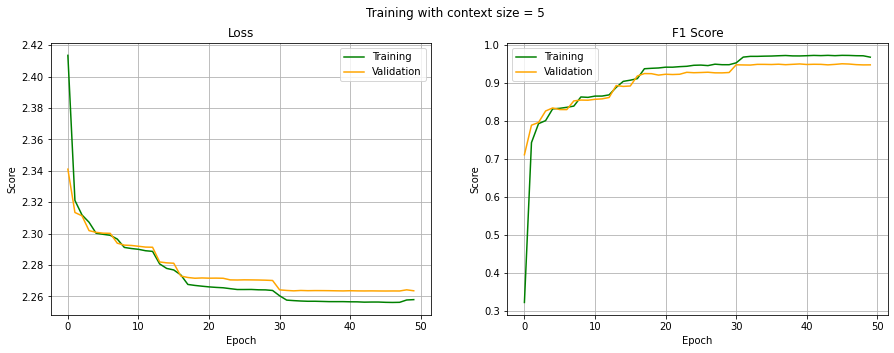

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9704, device='cuda:0'),
 tensor(0.9482, device='cuda:0'),
 tensor(0.9501, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9704, device='cuda:0'),
 tensor(0.9482, device='cuda:0'),
 tensor(0.9501, device='cuda:0'))

## Heatmap

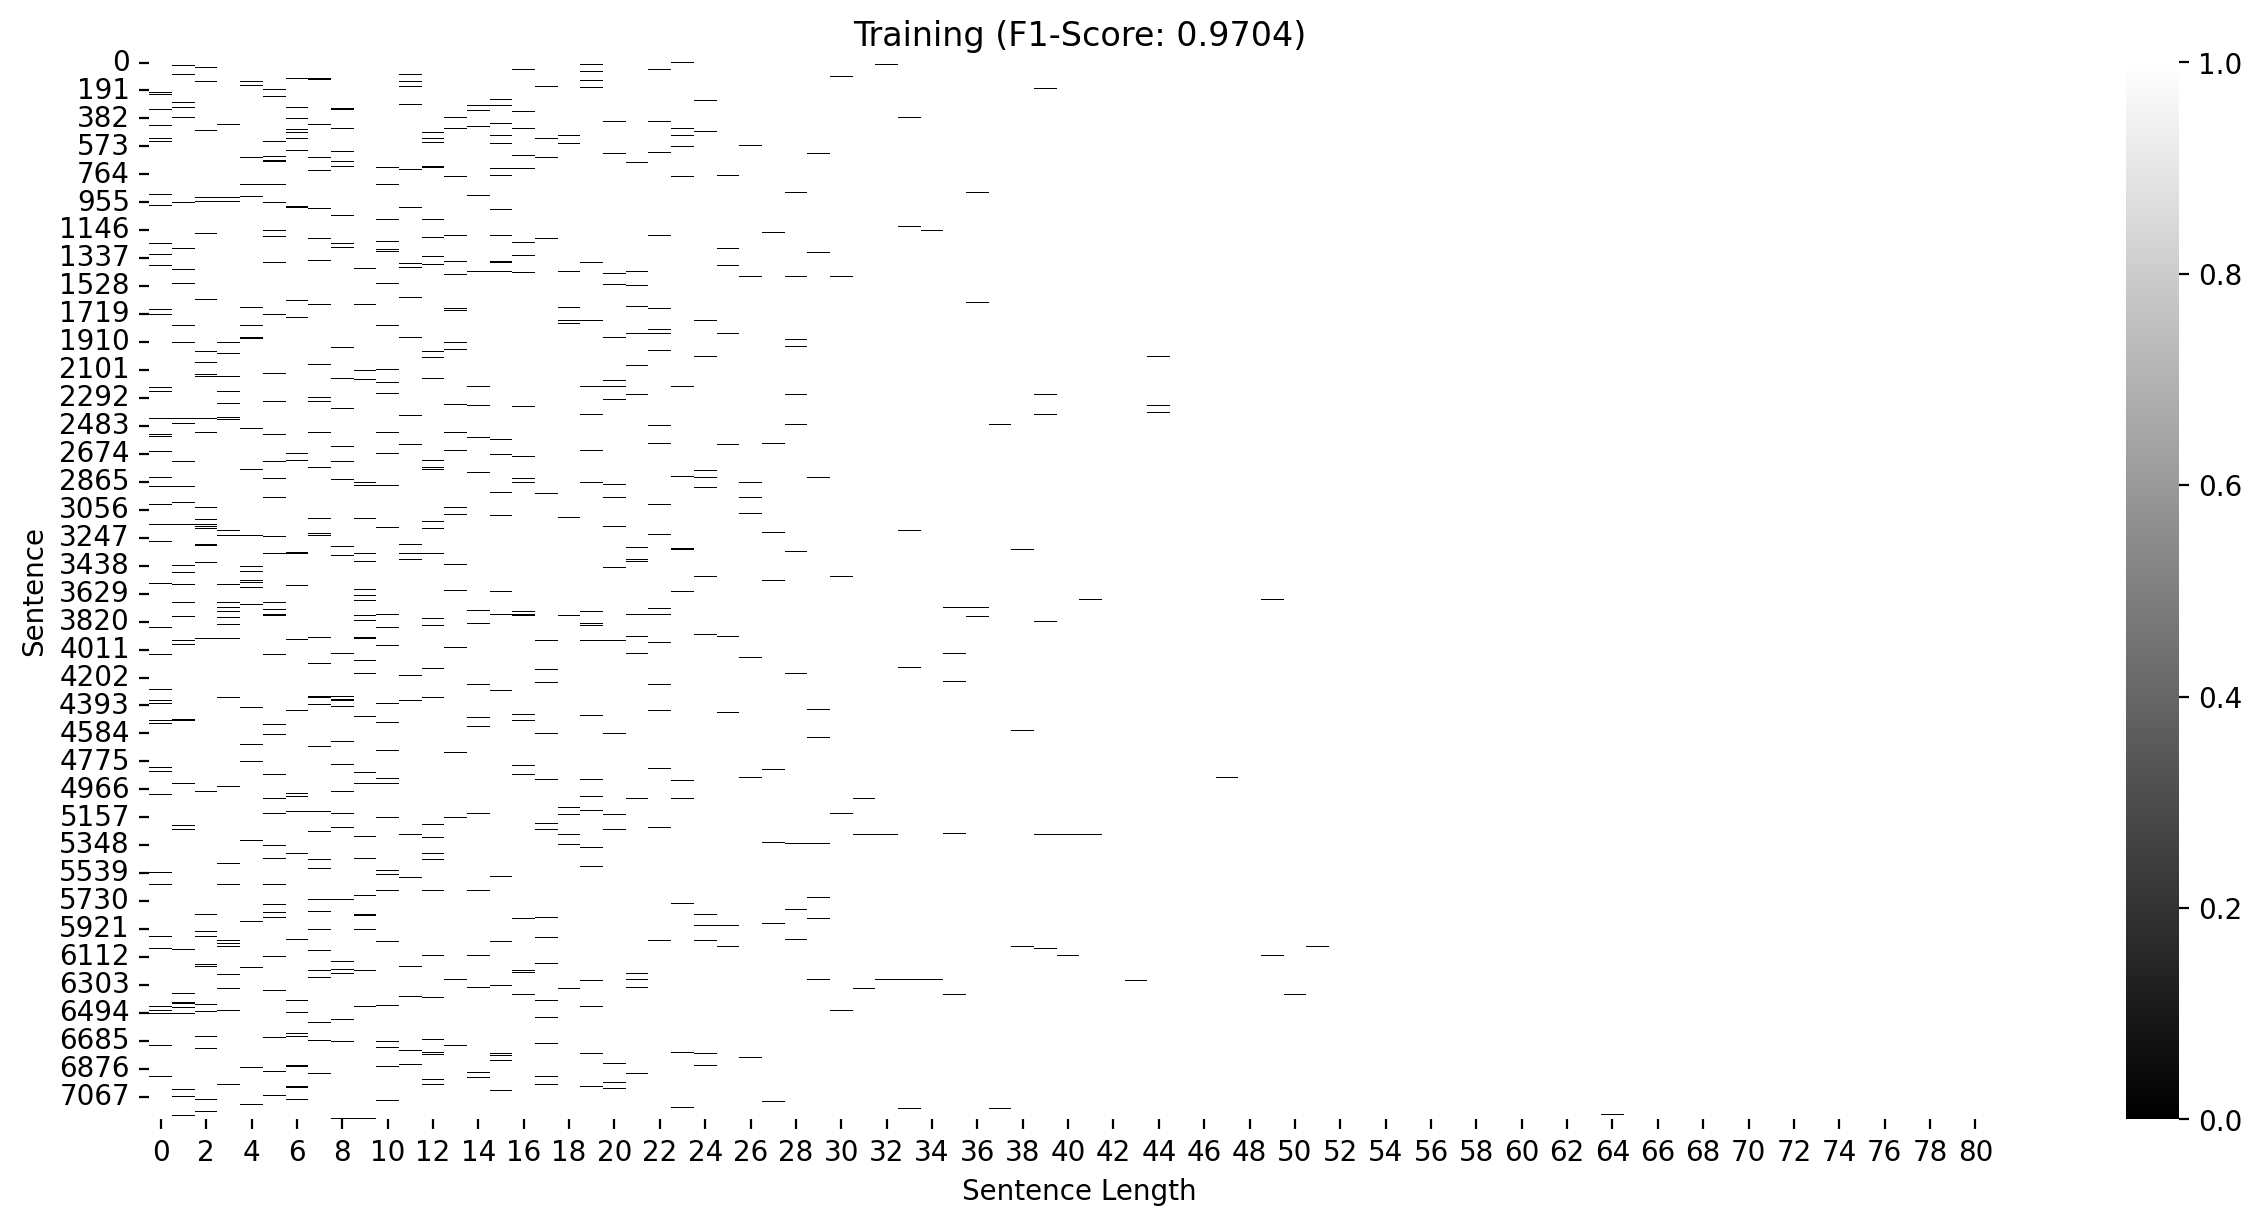

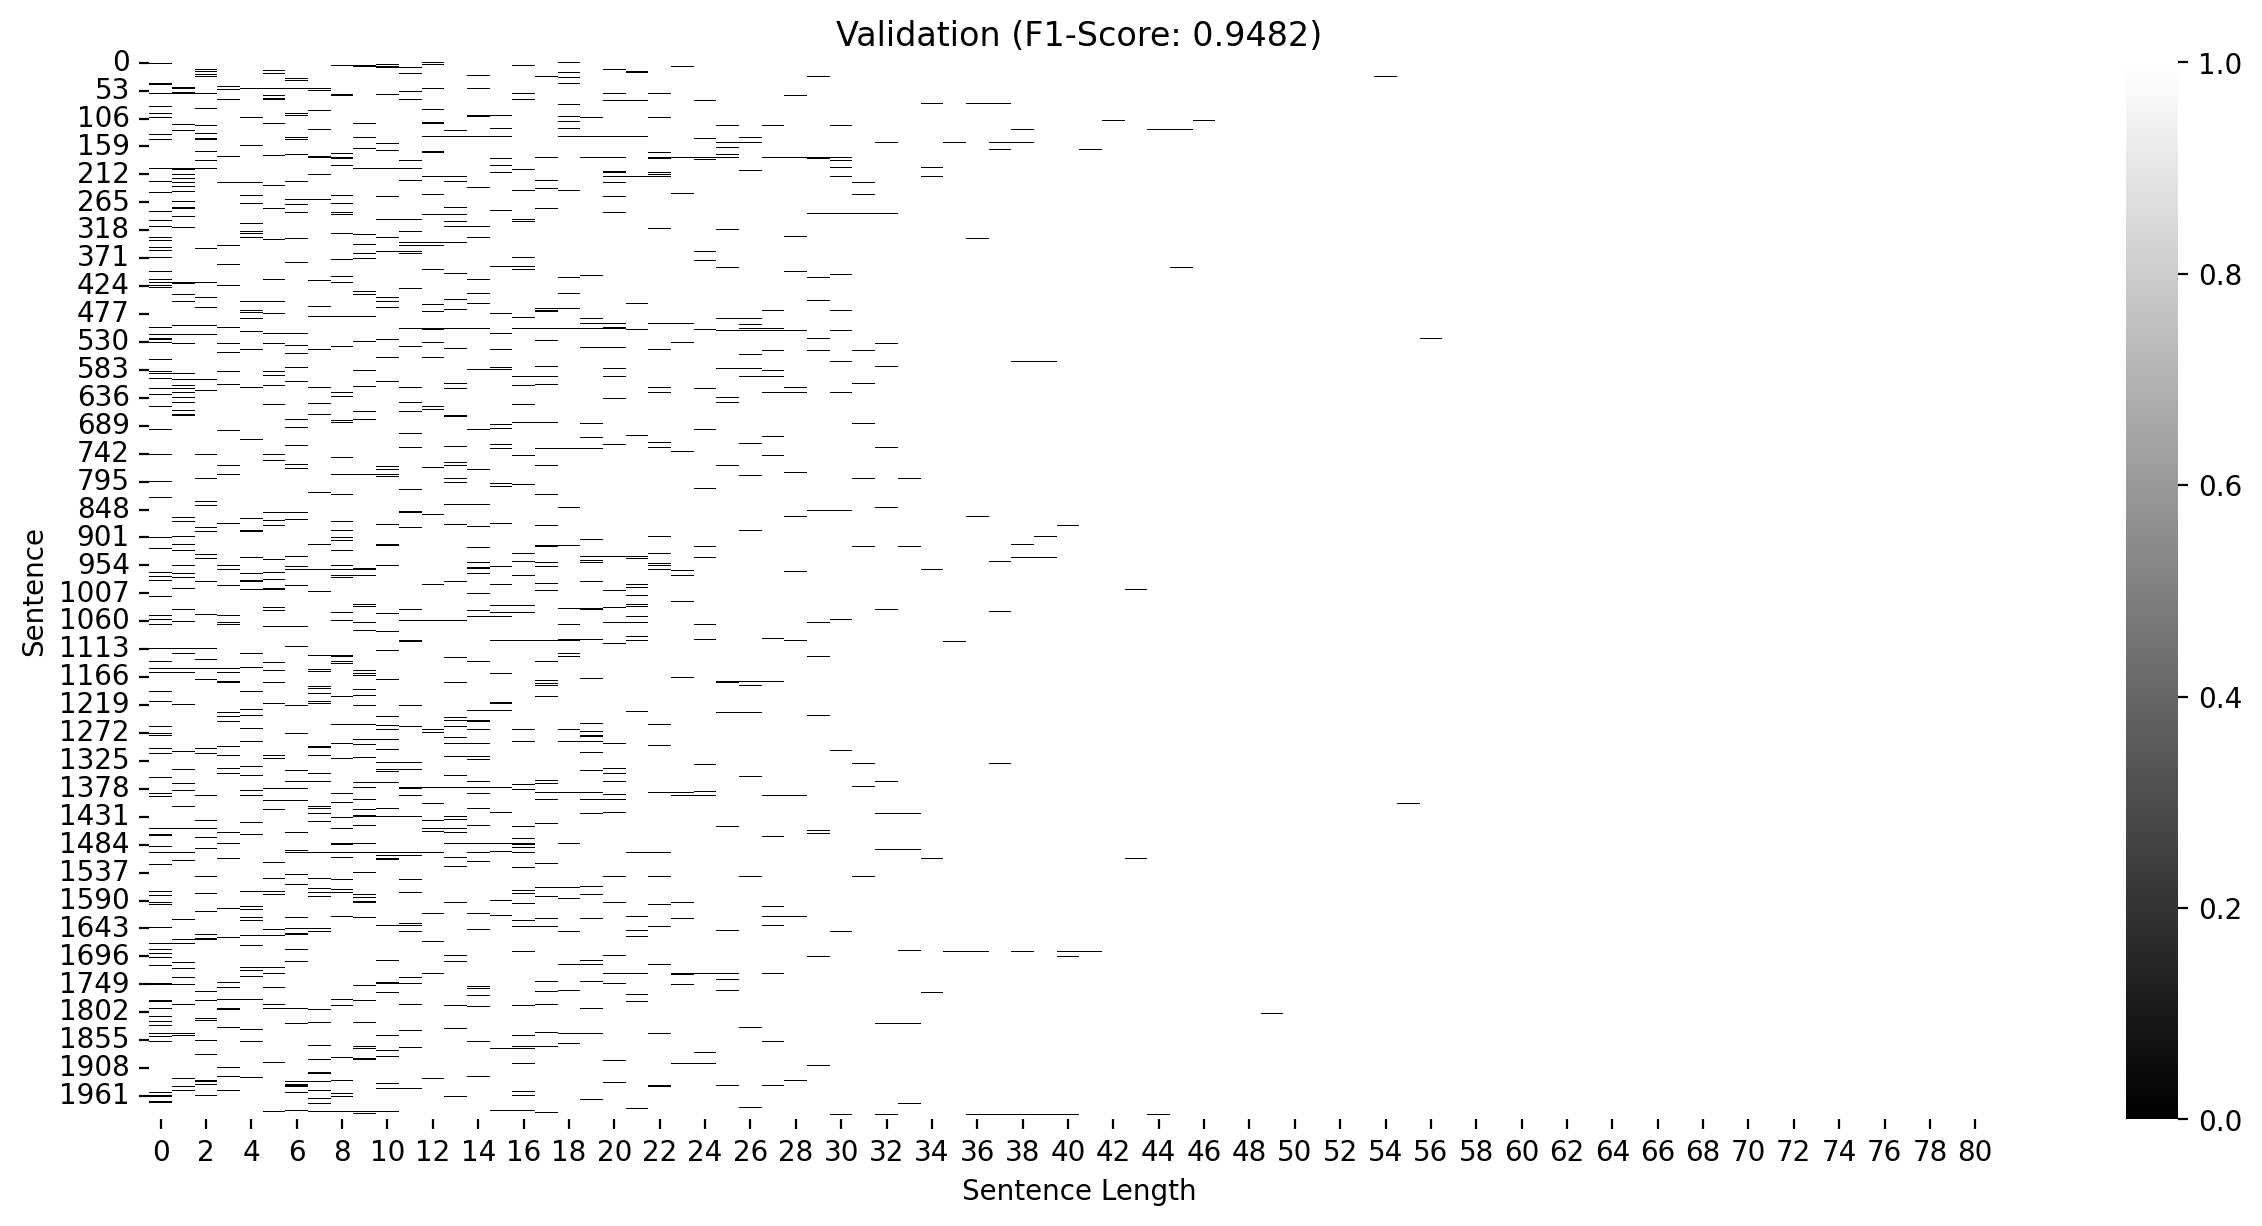

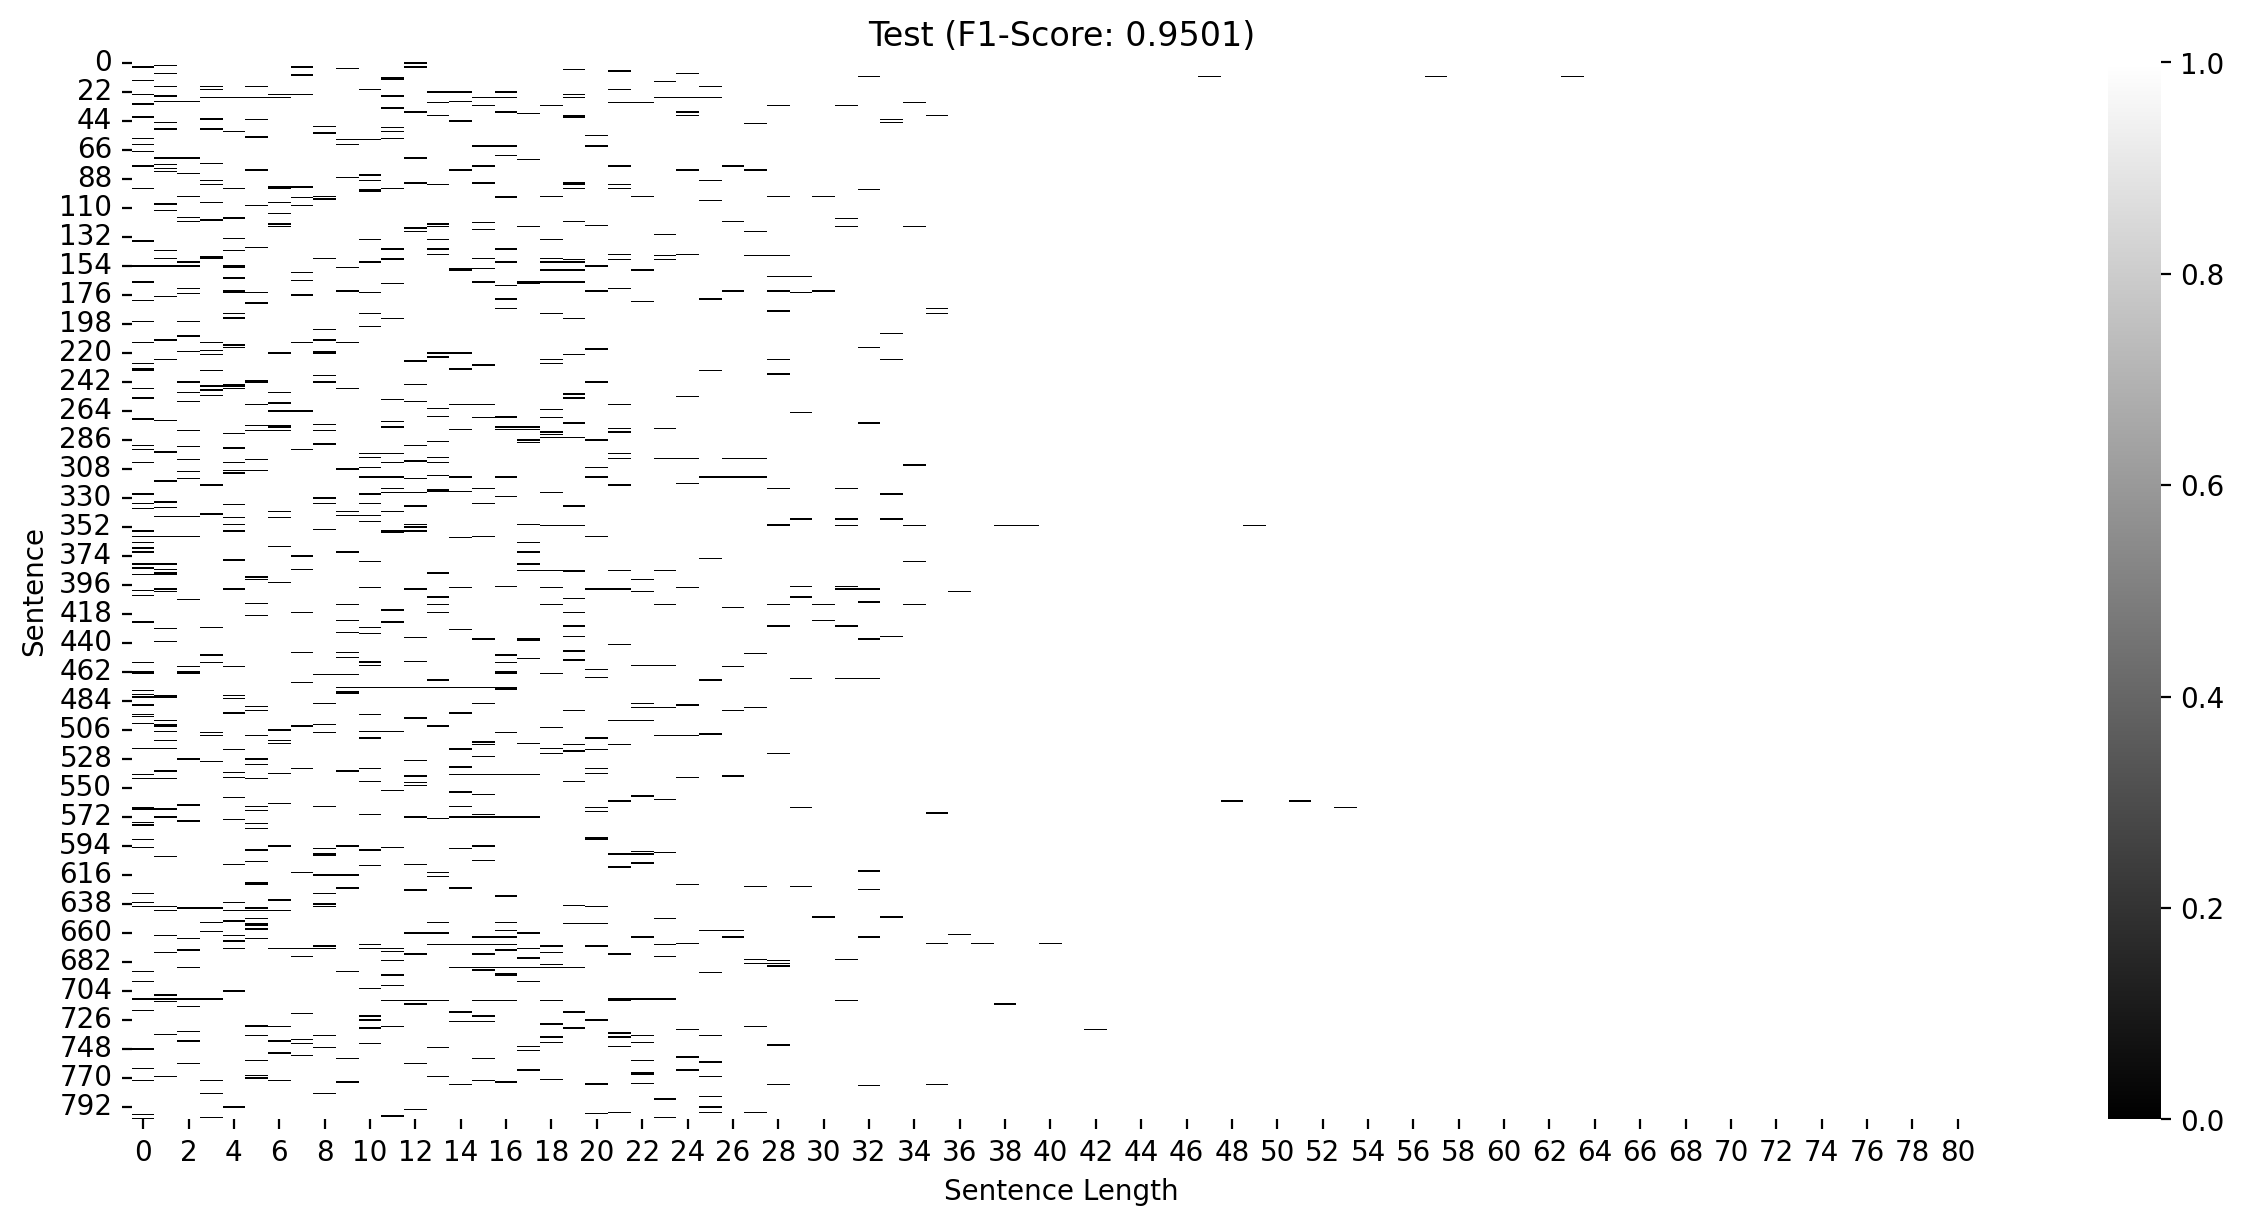

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


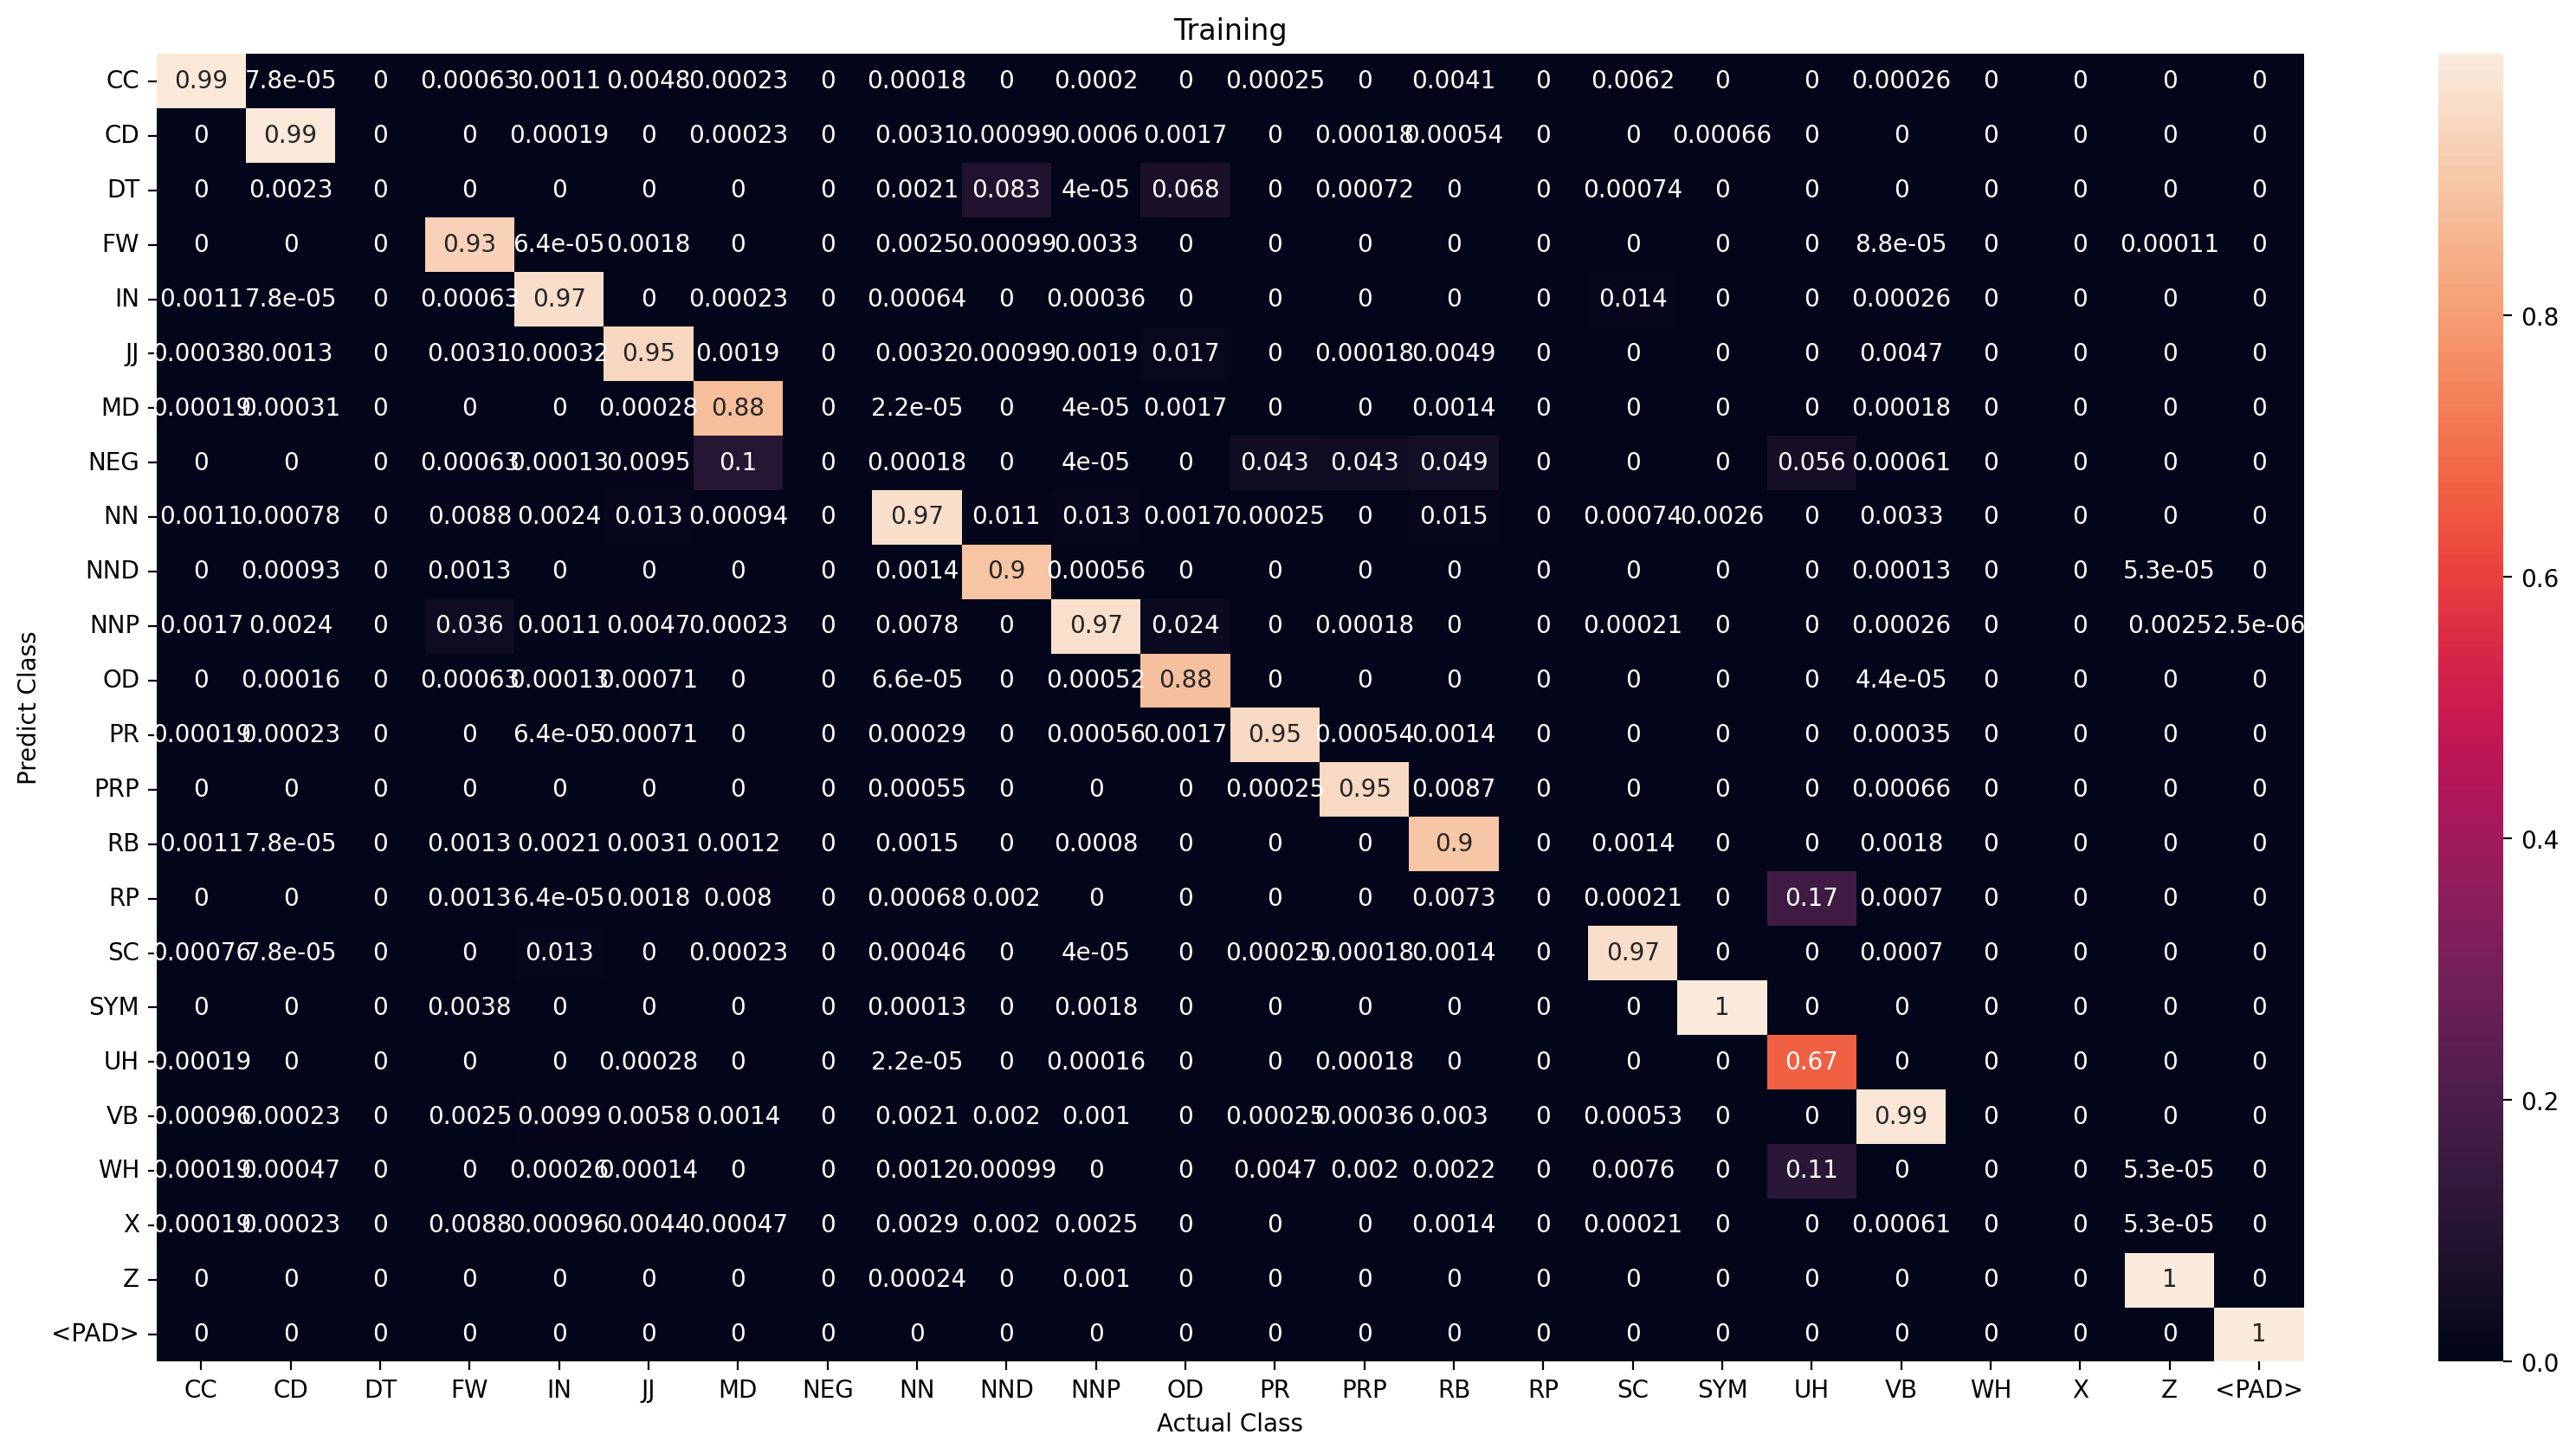

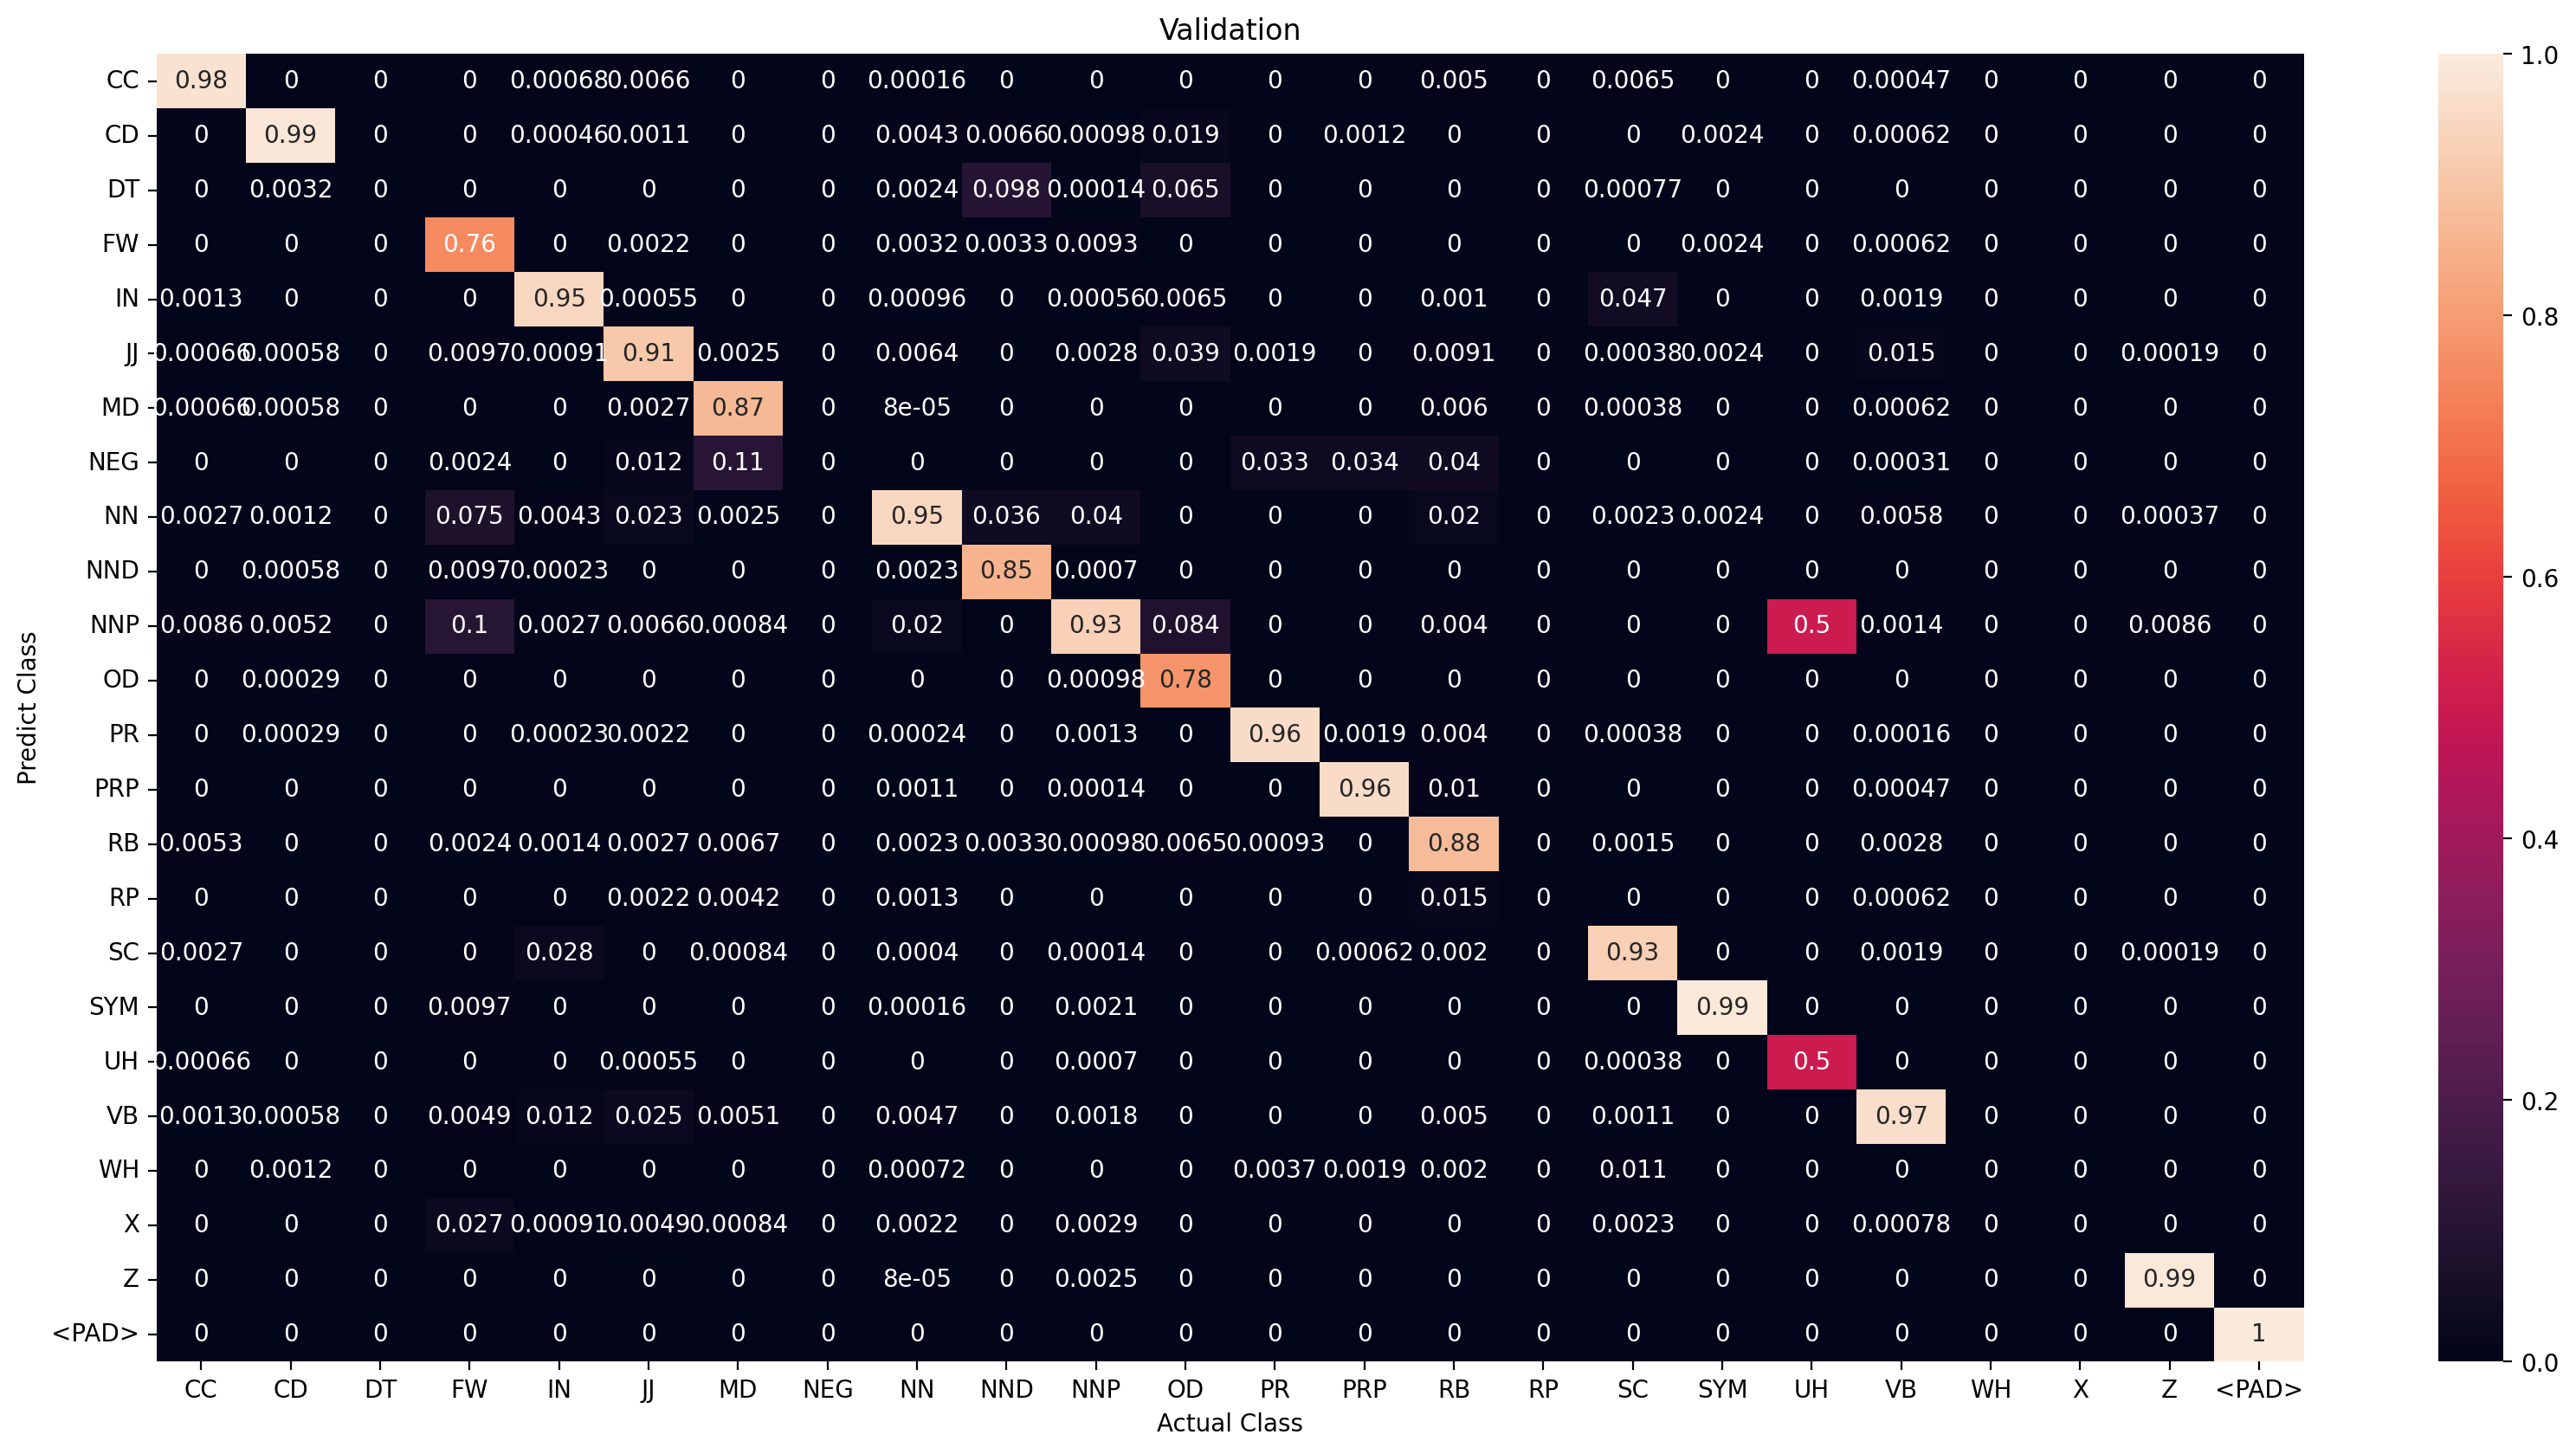

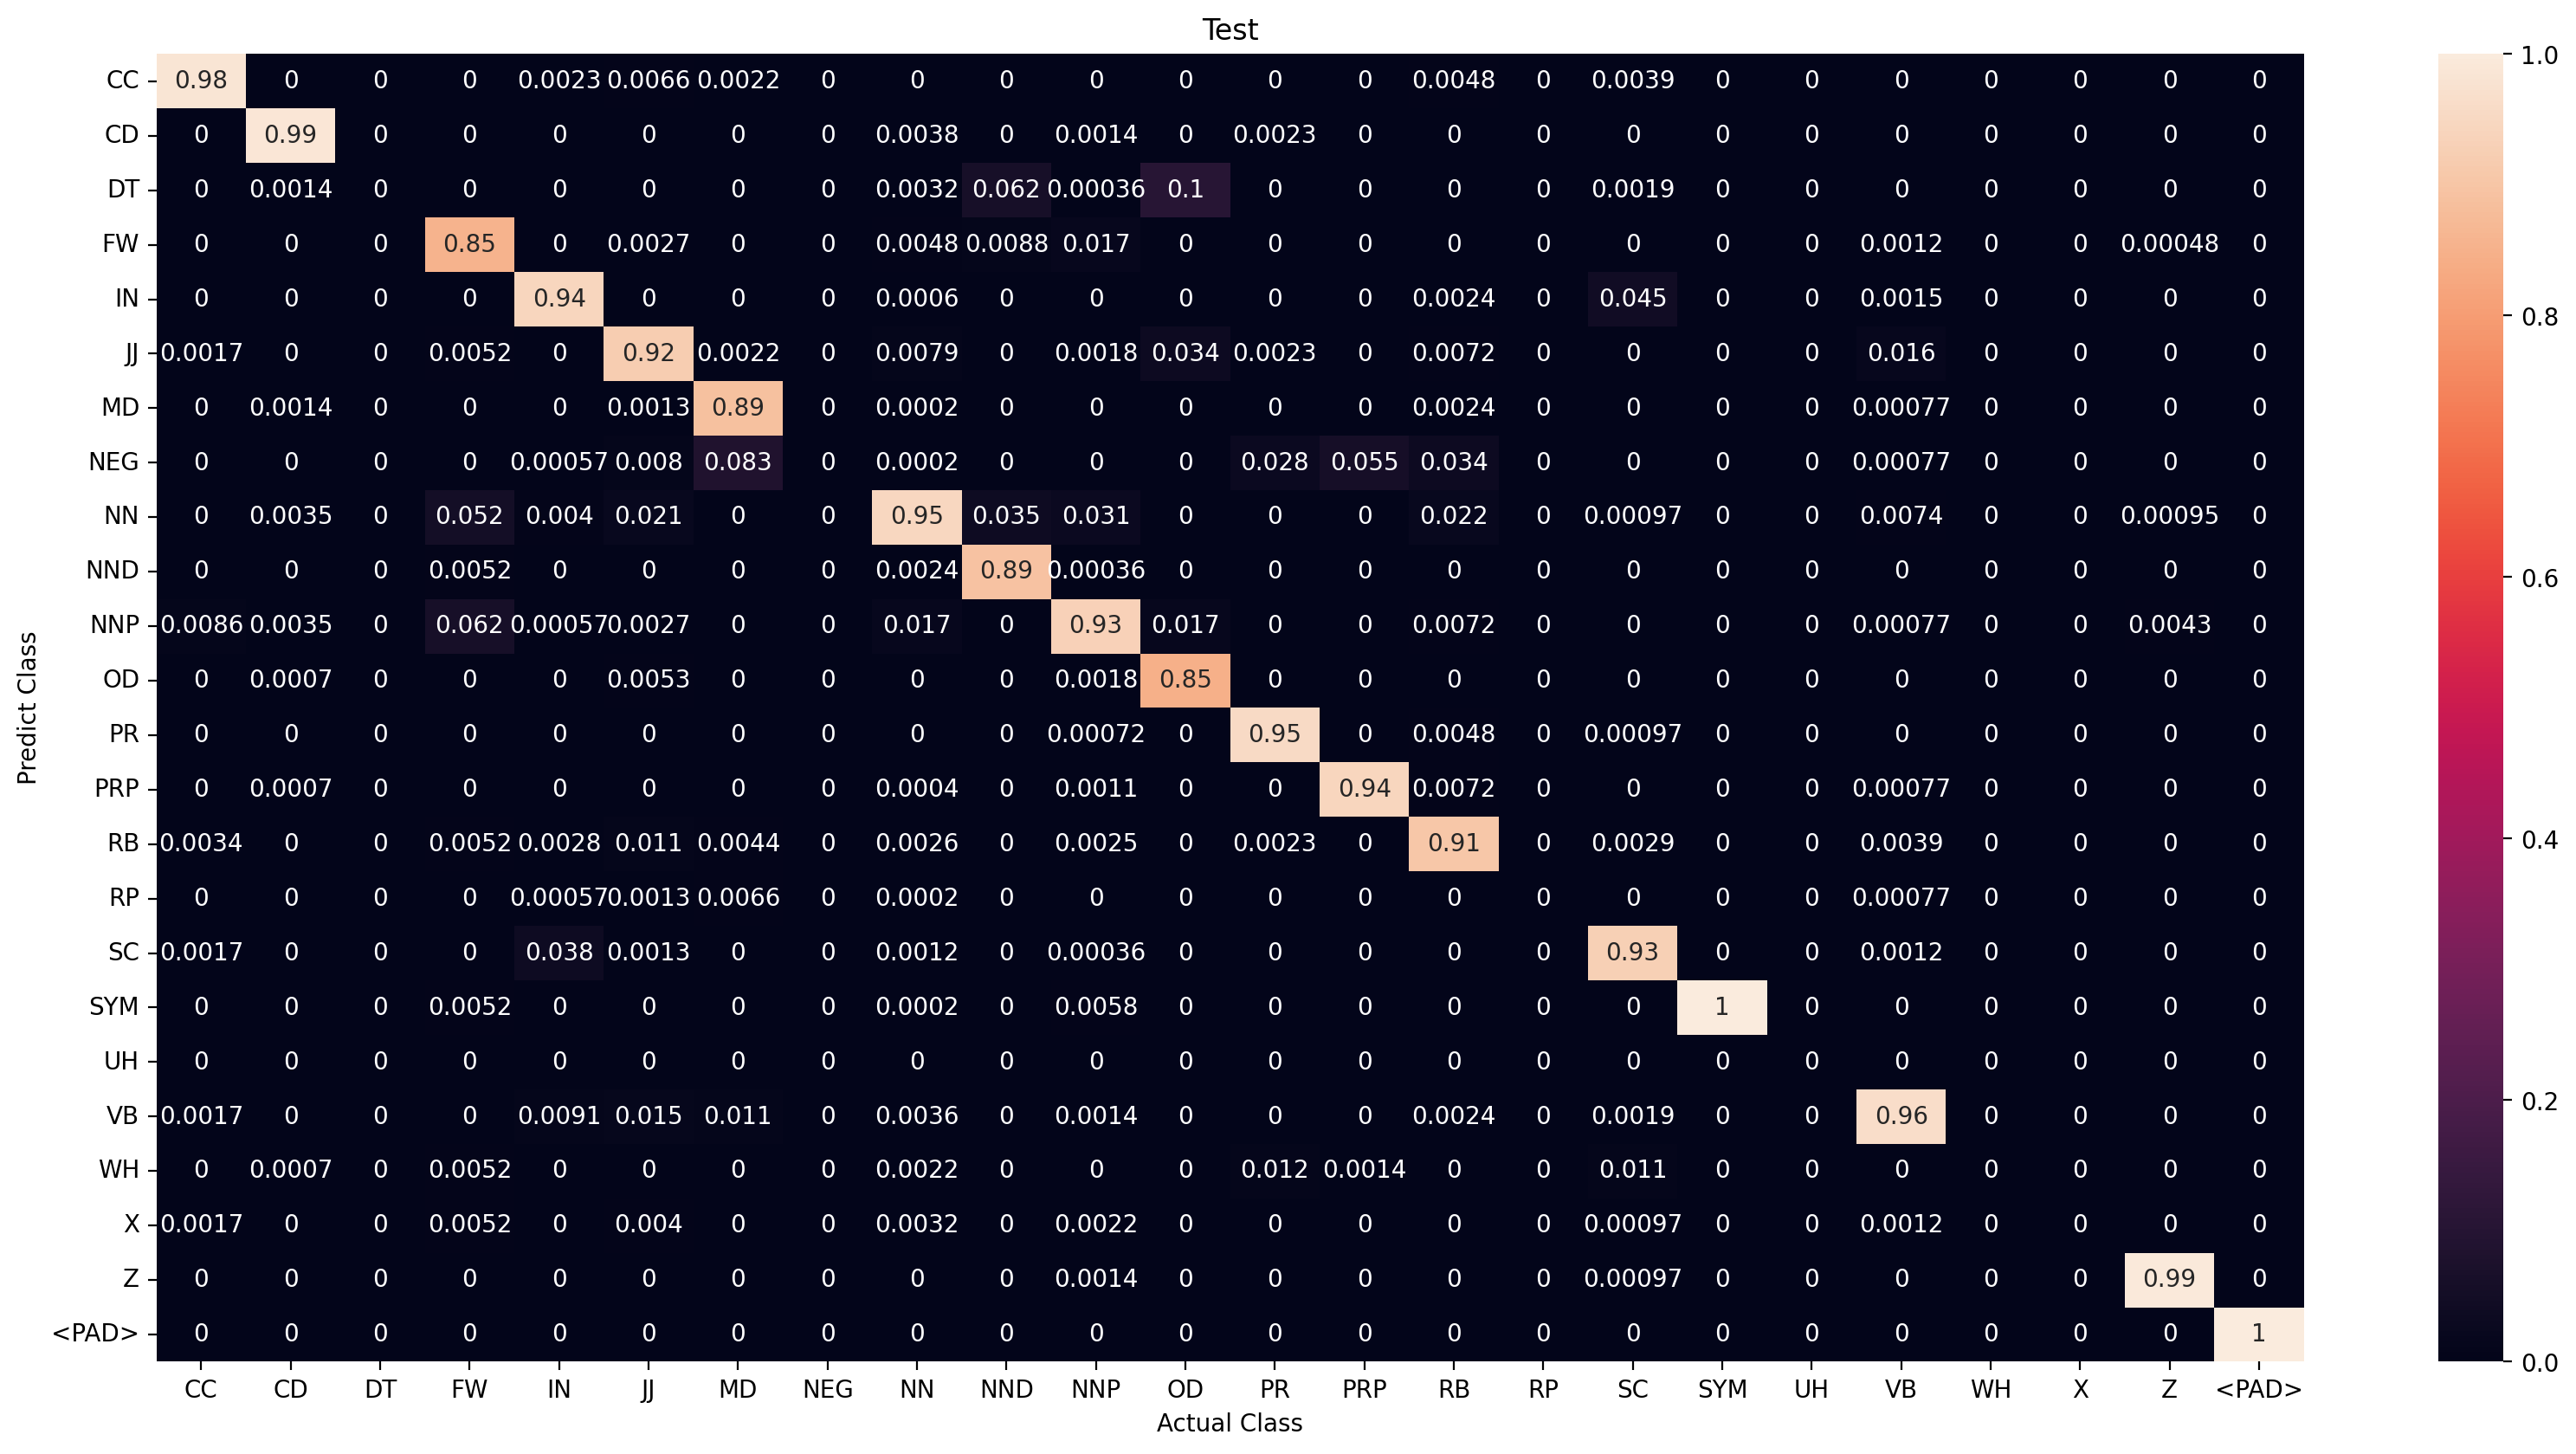

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5188       | CC    : 148      |
| CD    : 12904  | CD    : 12736      | CD    : 168      |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1481       | FW    : 216      |
| IN    : 15290  | IN    : 15104      | IN    : 186      |
| JJ    : 7049   | JJ    : 6680       | JJ    : 369      |
| MD    : 3783   | MD    : 3764       | MD    : 19       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44141      | NN    : 628      |
| NND   : 998    | NND   : 902        | NND   : 96       |
| NNP   : 24884  | NNP   : 24309      | NNP   : 575      |
| OD    : 550    | OD    : 523        | OD    : 27       |
| PR    : 3878   | PR    : 3824       | PR    : 54       |
| PRP   : 5355   | PRP   : 5282       | PRP   : 73       |
| RB    : 3517   | RB    : 3308       | RB    : 209      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19, 16,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11149
Wrong prediction            : 785
Percentage correct oov pred : 93.42215518686106

Validation
Number OOV token            : 3261
Correct prediction          : 2904
Wrong prediction            : 357
Percentage correct oov pred : 89.0524379024839

Test
Number OOV token            : 1367
Correct prediction          : 1219
Wrong prediction            : 148
Percentage correct oov pred : 89.17337234820776



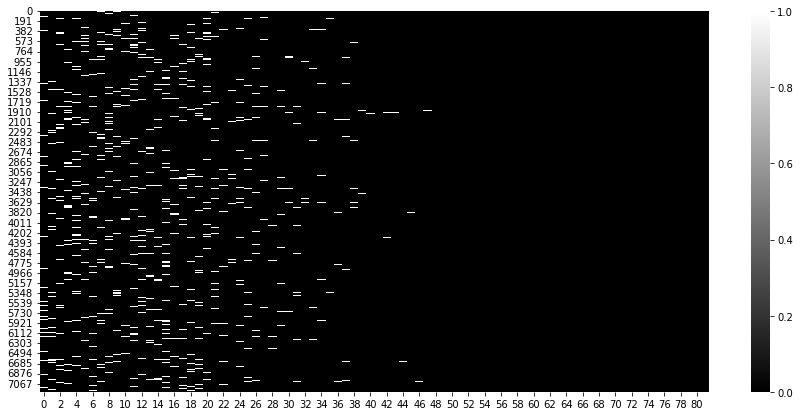

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

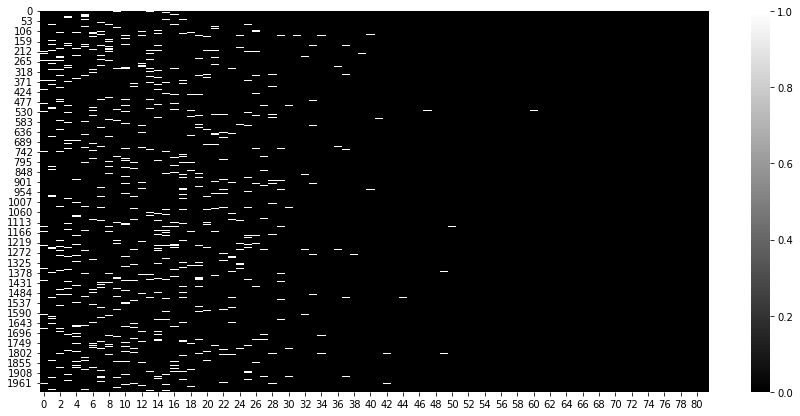

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

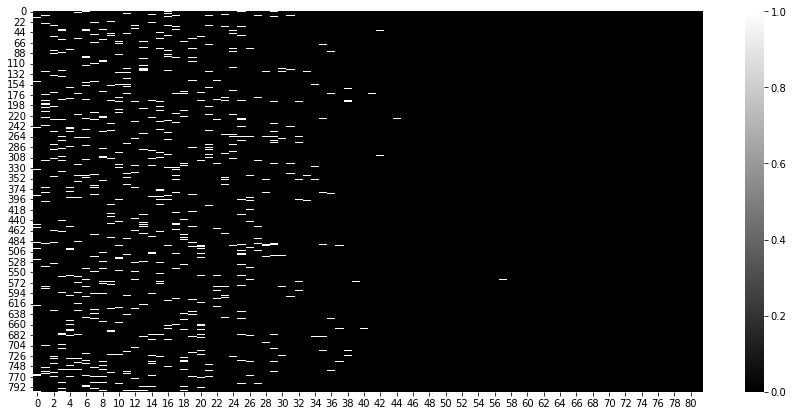

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);